Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import nltk
import pydot

Importing the dataset

In [2]:
data = pd.read_csv("newdata.csv")
data.head()

,Label,Comment
0,1,"I love my mom . No matter what we go through ,..."
1,1,Bump that music ... #imtryingtosleep #sarcasm
2,0,Mexican and black jokes are pretty much the sa...
3,0,How to find work you love :
4,0,@WolfpackAlan : You know what I like to do ? A...


Vizualization of data

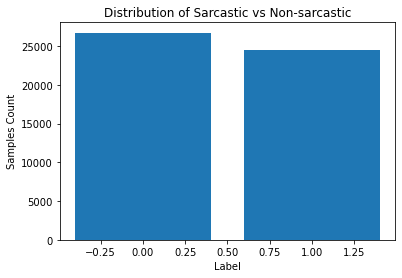

In [3]:
# Check the frequency of each label
label1 = len(data[data['Label'] == 1])
label0 = len(data[data['Label'] == 0])
plt.bar(x=[1, 0], height=[label1, label0])
plt.title("Distribution of Sarcastic vs Non-sarcastic")
plt.xlabel("Label")
plt.ylabel("Samples Count")
plt.show()

Cleaning of data

In [4]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"gonna", "going to", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text= re.sub(r"#sarcasm","",text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

Tokenization, Removal of stop words

In [5]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    Tweets = list()
    lines = df["Comment"].values.tolist()
    

    for line in lines:
        line = clean_text(line)
        
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        Tweets.append(words)
    return Tweets

Tweets = CleanTokenize(data)
Tweets[:10]

[['love',
  'mom',
  'matter',
  'go',
  'matter',
  'much',
  'argue',
  'know',
  'end',
  'always'],
 ['bump', 'music', 'imtryingtosleep'],
 ['mexican',
  'black',
  'jokes',
  'pretty',
  'much',
  'heard',
  'juan',
  'heard',
  'jamal'],
 ['find', 'work', 'love'],
 ['know', 'like', 'answer', 'questions'],
 ['seem', 'like', 'basketball', 'player', 'thank'],
 ['say', 'swag', 'every', 'sentence', 'doesnt', 'mean'],
 ['license', 'thing', 'would', 'use', 'mcdonalds'],
 ['people',
  'give',
  'directions',
  'tend',
  'concentrate',
  'hard',
  'trying',
  'look',
  'attentive',
  'forget',
  'listen'],
 ['love', 'stay', 'safe', 'wherever']]

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Train-Test-Split

In [30]:
validation_split = 0.1
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(Tweets)
sequences = tokenizer_obj.texts_to_sequences(Tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values
print(len(word_index))
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  38066
vocab size - 38067
38066


In [7]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (46070, 25)
Shape of y_train: (46070,)
<class 'numpy.int32'>
Shape of X_test_pad: (5118, 25)
Shape of y_test: (5118,)


Extraction of GloVe

In [25]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = '/content/'
f = open('glove.twitter.27B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


Embedding Matrix

In [26]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim), dtype='float32')
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

29267


Embedding Layer

In [27]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D,Flatten
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

Building the Model

In [28]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
model = Sequential()

model.add(embedding_layer)
model.add(Conv1D(filters=50, kernel_size=4, padding='same', activation='relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.0001)) )
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))

model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer =tf.keras.regularizers.l1( l=0.0001)))

optim = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['acc'])

print('Summary of the model : ')
print(model.summary())

Summary of the model : 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           3806700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 50)            20050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 50)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 50)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 9, 64)             3264      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (

In [35]:
history = model.fit(X_train_pad, y_train, batch_size=50, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/10
922/922 - 23s - loss: 0.6790 - acc: 0.6393 - val_loss: 0.6384 - val_acc: 0.6651
Epoch 2/10
922/922 - 19s - loss: 0.6332 - acc: 0.6793 - val_loss: 0.6126 - val_acc: 0.6930
Epoch 3/10
922/922 - 15s - loss: 0.6129 - acc: 0.6951 - val_loss: 0.6019 - val_acc: 0.7016
Epoch 4/10
922/922 - 22s - loss: 0.6019 - acc: 0.7054 - val_loss: 0.5945 - val_acc: 0.7100
Epoch 5/10
922/922 - 13s - loss: 0.5941 - acc: 0.7091 - val_loss: 0.5906 - val_acc: 0.7136
Epoch 6/10
922/922 - 21s - loss: 0.5895 - acc: 0.7137 - val_loss: 0.5866 - val_acc: 0.7163
Epoch 7/10
922/922 - 11s - loss: 0.5835 - acc: 0.7182 - val_loss: 0.5837 - val_acc: 0.7206
Epoch 8/10
922/922 - 11s - loss: 0.5814 - acc: 0.7189 - val_loss: 0.5816 - val_acc: 0.7259
Epoch 9/10
922/922 - 12s - loss: 0.5758 - acc: 0.7227 - val_loss: 0.5810 - val_acc: 0.7241
Epoch 10/10
922/922 - 12s - loss: 0.5737 - acc: 0.7270 - val_loss: 0.5812 - val_acc: 0.7206


Plotting results

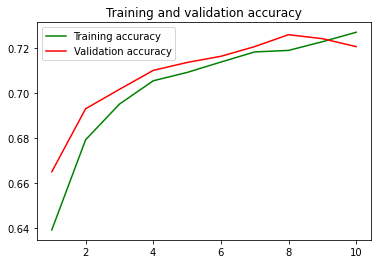

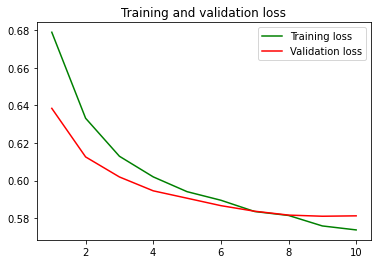

In [36]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Prediction

In [14]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"Comment":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's sarcasm!"
    else: return "It's not sarcasm!"

In [17]:
predict_sarcasm("Yes, I love to get drenched in the rain and the high temperature the very next day")

"It's sarcasm!"

In [48]:
predict_sarcasm("It's a sunny day")

"It's not sarcasm!"

In [49]:
predict_sarcasm("hi, I'm prathyusha")

"It's not sarcasm!"

In [50]:
predict_sarcasm("She is such a nerd.")

"It's sarcasm!"

In [52]:
predict_sarcasm("Yeah sure, that works.")

"It's sarcasm!"

In [64]:
predict_sarcasm("I work 40 hours a week for us to be this poor.")

"It's sarcasm!"

In [66]:
predict_sarcasm("I am busy right now, can I ignore you some other time?")

"It's sarcasm!"

In [69]:
predict_sarcasm("how are you ?")

"It's sarcasm!"

In [72]:
predict_sarcasm("We had a good day today.")

"It's not sarcasm!"

In [38]:
predict_sarcasm("Hello. Welcome to our house.")

"It's not sarcasm!"

In [ ]:
predict_sarcasm("")

Confusion Matrix

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Train accuracy: 0.7472107662253094
Test accuracy 0.7155138726064869
[[19633  4490]
 [ 7156 14791]]
[[2068  545]
 [ 911 1594]]


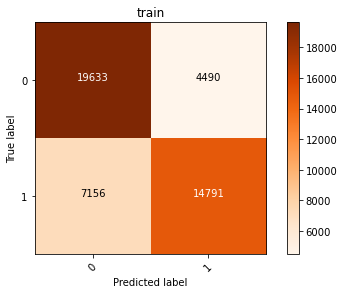

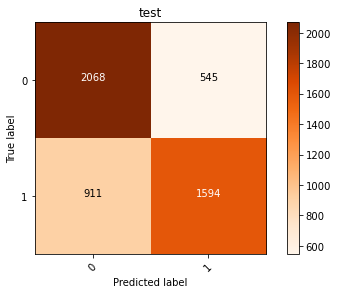

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

predictions_nn_train = model.predict(X_train_pad)
predictions_nn_test = model.predict(X_test_pad)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1


print('Train accuracy:', accuracy_score(y_train, predictions_nn_train))
print('Test accuracy', accuracy_score(y_test, predictions_nn_test))


cnf_matrix_train = confusion_matrix(y_train, predictions_nn_train)
cnf_matrix_test = confusion_matrix(y_test, predictions_nn_test)
plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='test')